In [1]:
!apt install ffmpeg
!pip install spleeter

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.7/48.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.3/77.3 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 54.5 MB/s eta 0:00:00
   

In [1]:
!pip install pydub

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf
from pydub import AudioSegment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report


In [4]:
dataset_path = "/content/drive/MyDrive/dataset/final_data"

train_data = tf.keras.utils.audio_dataset_from_directory(
    dataset_path,
    batch_size = 4,
    shuffle = True,
    validation_split = 0.2,
    subset = "training",
    output_sequence_length = 48000,
    ragged = False,
    label_mode = "categorical",
    labels = "inferred",
    sampling_rate = None,
    seed = 59
)


validation_data = tf.keras.utils.audio_dataset_from_directory(
    dataset_path,
    batch_size = 4,
    shuffle = False,
    validation_split = 0.2,
    subset = "validation",
    output_sequence_length = 48000,
    ragged = False,
    label_mode = "categorical",
    labels = "inferred",
    sampling_rate = None,
    seed = 59
)

Found 1895 files belonging to 16 classes.
Using 1516 files for training.
Found 1895 files belonging to 16 classes.
Using 379 files for validation.


In [5]:
train_labels = [y.numpy() for _, y in train_data]
val_labels = [y.numpy() for _, y in validation_data]

print("Train Labels Sample:", train_labels[0])
print("Validation Labels Sample:", val_labels[0])


Train Labels Sample: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
Validation Labels Sample: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


In [6]:

model = models.Sequential([

    layers.Conv1D(64, kernel_size=80, strides=16, activation="relu", input_shape=(48000, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=4),


    layers.Conv1D(128, kernel_size=3, activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=4),


    layers.Conv1D(256, kernel_size=3, activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=4),
    layers.Dropout(0.3),


    layers.Conv1D(512, kernel_size=3, activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=4),
    layers.Dropout(0.4),


    layers.GlobalAveragePooling1D(),
    layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(16, activation="softmax")
])


In [7]:

model.compile(
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001, decay=1e-6),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [8]:

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)


reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

history = model.fit(
    train_data,
    validation_data=validation_data,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

model.save("/content/drive/MyDrive/pre_trained_model/final_model_classmate.keras")
model.save("/content/drive/MyDrive/pre_trained_model/final_model_classmate.h5")

Epoch 1/20
379/379 [==============================] - 48s 120ms/step - loss: 3.8689 - accuracy: 0.2850 - val_loss: 5.8692 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/20
379/379 [==============================] - 45s 118ms/step - loss: 2.5795 - accuracy: 0.5013 - val_loss: 1.5682 - val_accuracy: 0.8575 - lr: 0.0010
Epoch 3/20
379/379 [==============================] - 45s 118ms/step - loss: 2.0101 - accuracy: 0.5831 - val_loss: 0.9217 - val_accuracy: 0.8892 - lr: 0.0010
Epoch 4/20
379/379 [==============================] - 45s 117ms/step - loss: 1.6351 - accuracy: 0.6497 - val_loss: 0.7277 - val_accuracy: 0.9235 - lr: 0.0010
Epoch 5/20
379/379 [==============================] - 44s 116ms/step - loss: 1.4578 - accuracy: 0.6603 - val_loss: 0.9641 - val_accuracy: 0.8153 - lr: 0.0010
Epoch 6/20
379/379 [==============================] - 45s 119ms/step - loss: 1.2581 - accuracy: 0.7091 - val_loss: 0.5343 - val_accuracy: 0.9551 - lr: 0.0010
Epoch 7/20
379/379 [============================

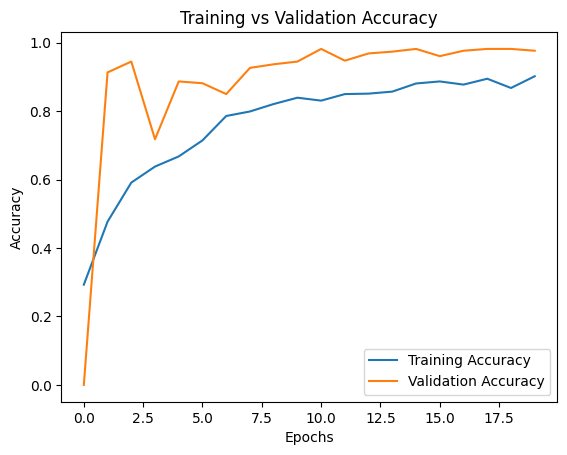

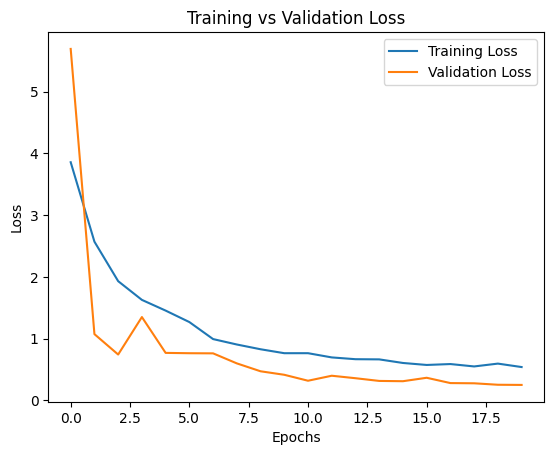

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()


plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()


In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

final_metrics = {
    "Epoch": len(train_accuracy),
    "Train Accuracy": train_accuracy[-1],
    "Validation Accuracy": val_accuracy[-1],
    "Train Loss": train_loss[-1],
    "Validation Loss": val_loss[-1]
}

final_metrics_df = pd.DataFrame([final_metrics])


print("\nFinal Training and Validation Metrics:\n")
print(final_metrics_df.to_string(index=False))



Final Training and Validation Metrics:

 Epoch  Train Accuracy  Validation Accuracy  Train Loss  Validation Loss
    20        0.901715             0.976253    0.541636         0.252221


In [ ]:
y_gt = np.concatenate([y for _, y in validation_data], axis=0)
y_gt = np.argmax(y_gt, axis=1)
predictions = model.predict(validation_data)
predicted_labels = np.argmax(predictions, axis=1)
conf_matrix = confusion_matrix(y_gt, predicted_labels)
conf_matrix


95/95 [==============================] - 1s 9ms/step


array([[  0,   0,   0,   0],
       [  0,   0,   0,   0],
       [  1,   0, 196,   0],
       [  0,   1,   7, 174]], dtype=int64)

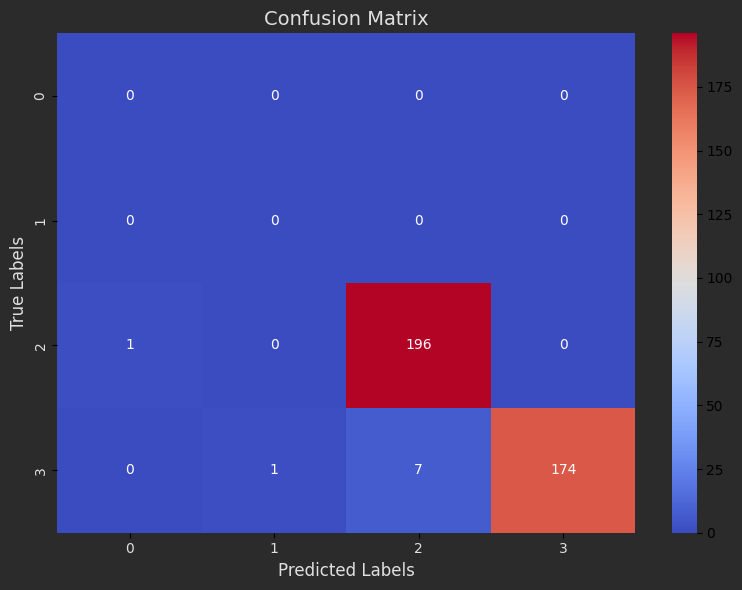

In [ ]:
import seaborn as sns

plt.figure(figsize=(8, 6))
fig = plt.gcf()
fig.patch.set_facecolor('#2b2b2b')

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="coolwarm", cbar=True)
plt.title("Confusion Matrix", fontsize=14, color='#e0e0e0')
plt.xlabel("Predicted Labels", fontsize=12, color='#e0e0e0')
plt.ylabel("True Labels", fontsize=12, color='#e0e0e0')
plt.xticks(color='#e0e0e0')
plt.yticks(color='#e0e0e0')

plt.tight_layout()
plt.show()

In [ ]:
print(classification_report(y_gt, predicted_labels))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
          14       0.97      0.99      0.98       197
          15       1.00      0.96      0.98       182

    accuracy                           0.98       379
   macro avg       0.49      0.49      0.49       379
weighted avg       0.98      0.98      0.98       379



c:\Users\delta2794900\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\delta2794900\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\delta2794900\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [ ]:
def predict_audio(audio_path):

    audio = AudioSegment.from_file(audio_path)
    audio = audio.set_channels(1).set_frame_rate(48000)
    audio = audio.set_sample_width(2)
    processed_audio_path = "audio.wav"
    audio.export(processed_audio_path, format="wav")


    audio_binary = tf.io.read_file(processed_audio_path)
    audio_tensor, sample_rate = tf.audio.decode_wav(
        audio_binary, desired_channels=1, desired_samples=48000
    )


    audio_tensor = tf.expand_dims(audio_tensor, axis=0)


    predictions = model.predict(audio_tensor)
    predicted_class = np.argmax(predictions, axis=1)
    return predicted_class[0]


audio_path = "bazazzan.wav"
predicted_class = predict_audio(audio_path)
print(f"Predicted class: {predicted_class}")

1/1 [==============================] - 0s 162ms/step
Predicted class: 1
